# Deep Dive: Suspension Pattern Analysis

**Purpose:** Data-driven analysis of suspension behavior patterns across Metro Manila LGUs

**Focus Areas:**
- Suspension frequency analysis by LGU ("trigger-happy" vs conservative)
- Announcement timing patterns (early/late declarations)
- Weather conditions during suspensions
- Geographic and temporal clustering
- LGU decision-making profiles

**Key Insights:**
This notebook answers: "Who suspends? When? Under what conditions?"

**References:**
- 01_create_master_dataset.ipynb (data source)
- 02_eda_and_core_model_all_features.ipynb (model training)
- 03_final_test_evaluation.ipynb (model performance)

## Section 0: Setup & Load Data

In [1]:
# Cell 0.1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
ANALYSIS_DIR = PROCESSED_DIR / 'nb04_analysis'
ANALYSIS_DIR.mkdir(exist_ok=True)

# LGU Mapping
LOCATION_MAPPING = {
    0: 'Manila', 1: 'Quezon City', 2: 'Caloocan', 3: 'Las Piñas',
    4: 'Makati', 5: 'Malabon', 6: 'Mandaluyong', 7: 'Marikina',
    8: 'Muntinlupa', 9: 'Navotas', 10: 'Parañaque', 11: 'Pasay',
    12: 'Pasig', 13: 'Pateros', 14: 'San Juan', 15: 'Taguig',
    16: 'Valenzuela'
}

print("✅ Libraries imported successfully")
print(f"Analysis directory: {ANALYSIS_DIR}")

✅ Libraries imported successfully
Analysis directory: ..\data\processed\nb04_analysis


In [2]:
# Cell 0.2: Load All Data
print("="*80)
print("LOADING DATASET")
print("="*80)

# Load all splits
train = pd.read_csv(str(PROCESSED_DIR / 'master_train.csv'))
val = pd.read_csv(str(PROCESSED_DIR / 'master_validation.csv'))
test = pd.read_csv(str(PROCESSED_DIR / 'master_test.csv'))

# Combine all data for complete analysis
all_data = pd.concat([train, val, test], ignore_index=True)
all_data['date'] = pd.to_datetime(all_data['date'])

print(f"\nDataset Summary:")
print(f"  Total rows: {len(all_data):,}")
print(f"  Date range: {all_data['date'].min().date()} to {all_data['date'].max().date()}")
print(f"  Unique LGUs: {all_data['lgu_id'].nunique()}")
print(f"  Total suspensions: {all_data['suspension_occurred'].sum():,}")
print(f"  Overall suspension rate: {all_data['suspension_occurred'].mean():.2%}")

# Extract suspension events only
suspensions = all_data[all_data['suspension_occurred'] == 1].copy()
print(f"\n✅ Loaded {len(suspensions):,} suspension events for analysis")

LOADING DATASET

Dataset Summary:
  Total rows: 18,700
  Date range: 2022-08-22 to 2025-08-25
  Unique LGUs: 17
  Total suspensions: 408
  Overall suspension rate: 2.18%

✅ Loaded 408 suspension events for analysis


## Section 1: LGU Suspension Frequency Analysis

**Goal:** Identify "trigger-happy" vs conservative LGUs

In [3]:
# Cell 1.1: Calculate Suspension Rates by LGU
print("="*80)
print("LGU SUSPENSION FREQUENCY RANKING")
print("="*80)

# Count total days and suspensions per LGU
lgu_stats = all_data.groupby('lgu_id').agg({
    'suspension_occurred': ['sum', 'count'],
    'date': 'nunique'
}).round(2)

lgu_stats.columns = ['Total_Suspensions', 'Total_Records', 'Unique_Days']
lgu_stats['Suspension_Rate_%'] = (lgu_stats['Total_Suspensions'] / lgu_stats['Total_Records'] * 100).round(3)
lgu_stats['LGU_Name'] = lgu_stats.index.map(LOCATION_MAPPING)

# Sort by suspension rate
lgu_stats = lgu_stats.sort_values('Suspension_Rate_%', ascending=False)

# Categorize LGUs
def categorize_lgu(rate):
    if rate >= 2.0:
        return '🔴 Trigger-Happy (≥2%)'
    elif rate >= 1.0:
        return '🟡 Moderate (1-2%)'
    elif rate >= 0.5:
        return '🟢 Conservative (0.5-1%)'
    else:
        return '⚪ Very Conservative (<0.5%)'

lgu_stats['Category'] = lgu_stats['Suspension_Rate_%'].apply(categorize_lgu)

print("\nLGU Suspension Frequency Ranking:")
print("="*80)
display_cols = ['LGU_Name', 'Total_Suspensions', 'Total_Records', 'Suspension_Rate_%', 'Category']
print(lgu_stats[display_cols].to_string())

# Show extremes
print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
most_active = lgu_stats.iloc[0]
least_active = lgu_stats.iloc[-1]

print(f"\n🔴 MOST ACTIVE (Trigger-Happy):")
print(f"   {most_active['LGU_Name']}: {most_active['Suspension_Rate_%']:.3f}% suspension rate")
print(f"   Total suspensions: {int(most_active['Total_Suspensions'])}")

print(f"\n⚪ LEAST ACTIVE (Very Conservative):")
print(f"   {least_active['LGU_Name']}: {least_active['Suspension_Rate_%']:.3f}% suspension rate")
print(f"   Total suspensions: {int(least_active['Total_Suspensions'])}")

ratio = most_active['Suspension_Rate_%'] / least_active['Suspension_Rate_%']
print(f"\n📊 Difference Factor: {ratio:.1f}x")
print(f"   {most_active['LGU_Name']} suspends {ratio:.1f}x more frequently than {least_active['LGU_Name']}")

# Save results
lgu_stats.to_csv(ANALYSIS_DIR / 'lgu_suspension_frequency.csv')
print(f"\n✅ Results saved to lgu_suspension_frequency.csv")

LGU SUSPENSION FREQUENCY RANKING

LGU Suspension Frequency Ranking:
           LGU_Name  Total_Suspensions  Total_Records  Suspension_Rate_%                     Category
lgu_id                                                                                               
5           Malabon                 36           1100              3.273        🔴 Trigger-Happy (≥2%)
7          Marikina                 30           1100              2.727        🔴 Trigger-Happy (≥2%)
2          Caloocan                 30           1100              2.727        🔴 Trigger-Happy (≥2%)
16       Valenzuela                 27           1100              2.455        🔴 Trigger-Happy (≥2%)
9           Navotas                 26           1100              2.364        🔴 Trigger-Happy (≥2%)
8        Muntinlupa                 26           1100              2.364        🔴 Trigger-Happy (≥2%)
6       Mandaluyong                 25           1100              2.273        🔴 Trigger-Happy (≥2%)
10        Para

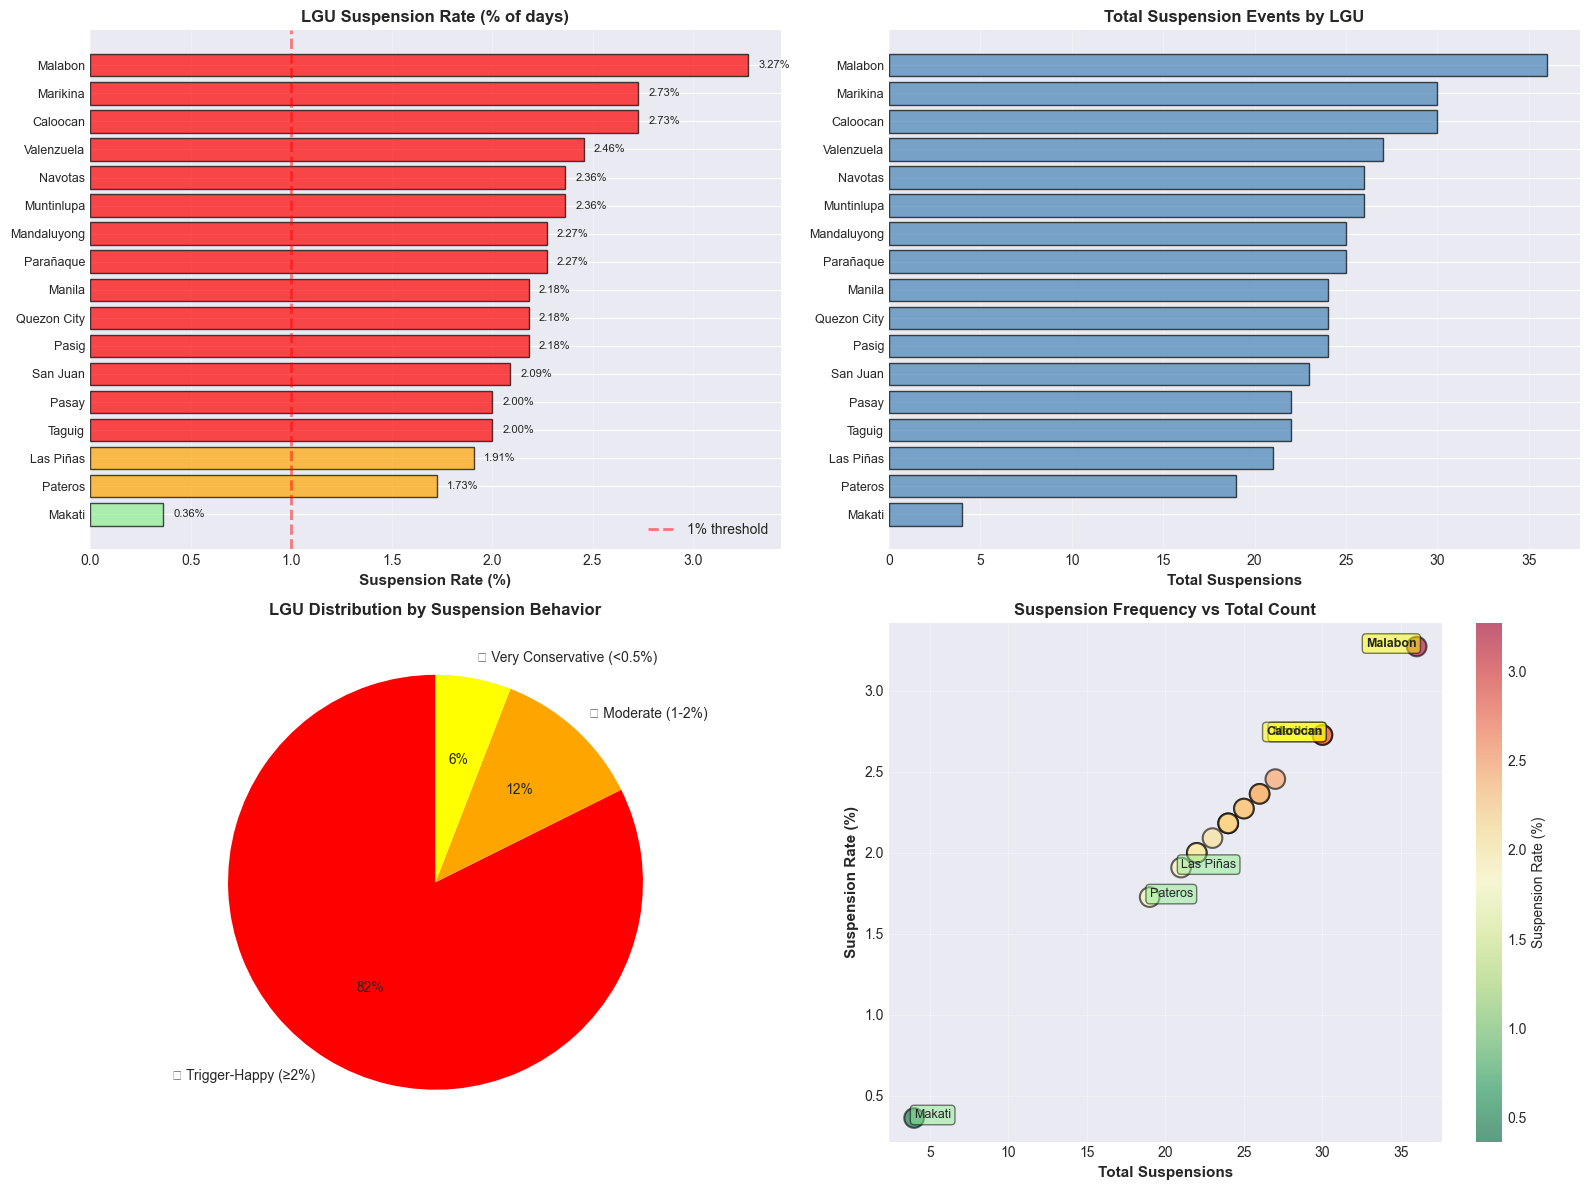

✅ Visualization complete


In [4]:
# Cell 1.2: Visualize LGU Suspension Rates
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Horizontal bar chart - Suspension Rate %
ax = axes[0, 0]
sorted_stats = lgu_stats.sort_values('Suspension_Rate_%')
colors = ['red' if r >= 2.0 else 'orange' if r >= 1.0 else 'yellow' if r >= 0.5 else 'lightgreen' 
          for r in sorted_stats['Suspension_Rate_%']]
ax.barh(range(len(sorted_stats)), sorted_stats['Suspension_Rate_%'], color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(sorted_stats)))
ax.set_yticklabels(sorted_stats['LGU_Name'], fontsize=9)
ax.set_xlabel('Suspension Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('LGU Suspension Rate (% of days)', fontsize=12, fontweight='bold')
ax.axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='1% threshold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Add values on bars
for i, v in enumerate(sorted_stats['Suspension_Rate_%']):
    ax.text(v + 0.05, i, f'{v:.2f}%', va='center', fontsize=8)

# 2. Total suspension counts
ax = axes[0, 1]
sorted_counts = lgu_stats.sort_values('Total_Suspensions')
ax.barh(range(len(sorted_counts)), sorted_counts['Total_Suspensions'], color='steelblue', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(sorted_counts)))
ax.set_yticklabels(sorted_counts['LGU_Name'], fontsize=9)
ax.set_xlabel('Total Suspensions', fontsize=11, fontweight='bold')
ax.set_title('Total Suspension Events by LGU', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 3. Category distribution (pie chart)
ax = axes[1, 0]
category_counts = lgu_stats['Category'].value_counts()
colors_pie = ['red', 'orange', 'yellow', 'lightgreen']
ax.pie(category_counts.values, labels=category_counts.index, autopct='%1.0f%%', 
       colors=colors_pie[:len(category_counts)], startangle=90, textprops={'fontsize': 10})
ax.set_title('LGU Distribution by Suspension Behavior', fontsize=12, fontweight='bold')

# 4. Scatter: Rate vs Count
ax = axes[1, 1]
scatter = ax.scatter(lgu_stats['Total_Suspensions'], lgu_stats['Suspension_Rate_%'], 
                    s=200, alpha=0.6, c=lgu_stats['Suspension_Rate_%'], 
                    cmap='RdYlGn_r', edgecolors='black', linewidth=1.5)
ax.set_xlabel('Total Suspensions', fontsize=11, fontweight='bold')
ax.set_ylabel('Suspension Rate (%)', fontsize=11, fontweight='bold')
ax.set_title('Suspension Frequency vs Total Count', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Annotate key LGUs
for idx in lgu_stats.index[:3]:  # Top 3
    ax.annotate(lgu_stats.loc[idx, 'LGU_Name'], 
               (lgu_stats.loc[idx, 'Total_Suspensions'], lgu_stats.loc[idx, 'Suspension_Rate_%']),
               fontsize=9, fontweight='bold', ha='right', 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))

for idx in lgu_stats.index[-3:]:  # Bottom 3
    ax.annotate(lgu_stats.loc[idx, 'LGU_Name'], 
               (lgu_stats.loc[idx, 'Total_Suspensions'], lgu_stats.loc[idx, 'Suspension_Rate_%']),
               fontsize=9, ha='left',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.5))

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Suspension Rate (%)', fontsize=10)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'lgu_suspension_frequency_viz.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization complete")

## Section 2: Temporal Patterns - When Do Suspensions Happen?

In [5]:
# Cell 2.1: Monthly and Seasonal Distribution
print("="*80)
print("TEMPORAL SUSPENSION PATTERNS")
print("="*80)

# Add temporal features
suspensions['year'] = suspensions['date'].dt.year
suspensions['month'] = suspensions['date'].dt.month
suspensions['month_name'] = suspensions['date'].dt.strftime('%B')
suspensions['day_of_week'] = suspensions['date'].dt.dayofweek
suspensions['day_name'] = suspensions['date'].dt.strftime('%A')
suspensions['week_of_year'] = suspensions['date'].dt.isocalendar().week

# Monthly distribution
monthly_counts = suspensions['month'].value_counts().sort_index()
print("\nSuspensions by Month:")
for month, count in monthly_counts.items():
    month_name = suspensions[suspensions['month'] == month]['month_name'].iloc[0]
    pct = count / len(suspensions) * 100
    print(f"  {month_name:10} : {count:3d} ({pct:5.1f}%)")

# Identify peak months
peak_month = monthly_counts.idxmax()
peak_name = suspensions[suspensions['month'] == peak_month]['month_name'].iloc[0]
print(f"\n📊 Peak Month: {peak_name} ({monthly_counts.max()} suspensions)")

# Day of week analysis
dow_counts = suspensions['day_of_week'].value_counts().sort_index()
print("\nSuspensions by Day of Week:")
for dow, count in dow_counts.items():
    day_name = suspensions[suspensions['day_of_week'] == dow]['day_name'].iloc[0]
    pct = count / len(suspensions) * 100
    print(f"  {day_name:10} : {count:3d} ({pct:5.1f}%)")

# School days vs non-school days
if 'is_school_day' in suspensions.columns:
    school_day_counts = suspensions['is_school_day'].value_counts()
    print("\nSchool Days vs Non-School Days:")
    print(f"  School days: {school_day_counts.get(1, 0)} ({school_day_counts.get(1, 0)/len(suspensions)*100:.1f}%)")
    print(f"  Non-school days: {school_day_counts.get(0, 0)} ({school_day_counts.get(0, 0)/len(suspensions)*100:.1f}%)")

TEMPORAL SUSPENSION PATTERNS

Suspensions by Month:
  January    :   8 (  2.0%)
  May        :   1 (  0.2%)
  July       : 115 ( 28.2%)
  August     :  68 ( 16.7%)
  September  : 103 ( 25.2%)
  October    :  81 ( 19.9%)
  November   :  32 (  7.8%)

📊 Peak Month: July (115 suspensions)

Suspensions by Day of Week:
  Monday     : 105 ( 25.7%)
  Tuesday    :  55 ( 13.5%)
  Wednesday  :  79 ( 19.4%)
  Thursday   :  87 ( 21.3%)
  Friday     :  63 ( 15.4%)
  Saturday   :  19 (  4.7%)

School Days vs Non-School Days:
  School days: 352 (86.3%)
  Non-school days: 56 (13.7%)


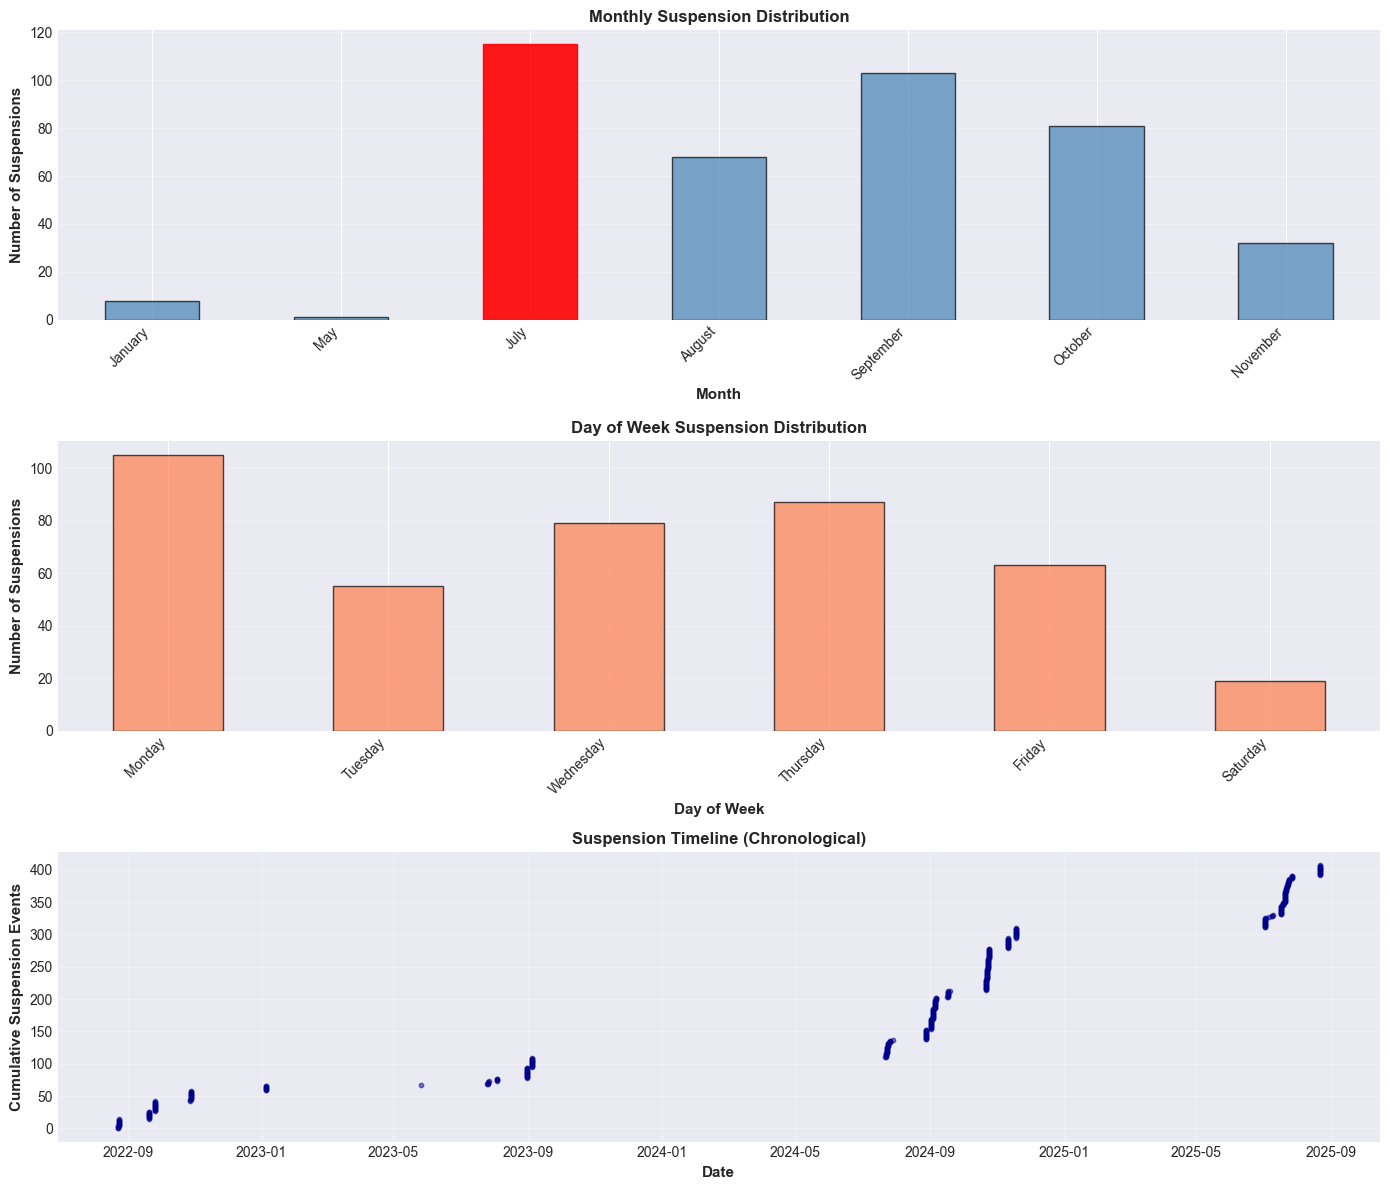

✅ Temporal visualization complete


In [6]:
# Cell 2.2: Visualize Temporal Patterns
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Monthly timeline
ax = axes[0]
monthly_counts.plot(kind='bar', ax=ax, color='steelblue', alpha=0.7, edgecolor='black')
month_names = [suspensions[suspensions['month'] == m]['month_name'].iloc[0] for m in monthly_counts.index]
ax.set_xticklabels(month_names, rotation=45, ha='right')
ax.set_ylabel('Number of Suspensions', fontsize=11, fontweight='bold')
ax.set_xlabel('Month', fontsize=11, fontweight='bold')
ax.set_title('Monthly Suspension Distribution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Highlight peak month
peak_idx = list(monthly_counts.index).index(peak_month)
ax.patches[peak_idx].set_color('red')
ax.patches[peak_idx].set_alpha(0.9)

# 2. Day of week distribution
ax = axes[1]
dow_counts.plot(kind='bar', ax=ax, color='coral', alpha=0.7, edgecolor='black')
day_names = [suspensions[suspensions['day_of_week'] == d]['day_name'].iloc[0] for d in dow_counts.index]
ax.set_xticklabels(day_names, rotation=45, ha='right')
ax.set_ylabel('Number of Suspensions', fontsize=11, fontweight='bold')
ax.set_xlabel('Day of Week', fontsize=11, fontweight='bold')
ax.set_title('Day of Week Suspension Distribution', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 3. Timeline - all suspensions
ax = axes[2]
suspensions_sorted = suspensions.sort_values('date')
dates = suspensions_sorted['date']
ax.scatter(dates, range(len(dates)), alpha=0.5, s=10, c='darkblue')
ax.set_xlabel('Date', fontsize=11, fontweight='bold')
ax.set_ylabel('Cumulative Suspension Events', fontsize=11, fontweight='bold')
ax.set_title('Suspension Timeline (Chronological)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'temporal_suspension_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Temporal visualization complete")

## Section 3: Weather Conditions During Suspensions

In [7]:
# Cell 3.1: Weather Statistics for Suspension Days
print("="*80)
print("WEATHER CONDITIONS DURING SUSPENSIONS")
print("="*80)

# Key weather features
weather_features = [
    'hist_precipitation_sum_t1',
    'fcst_precipitation_sum',
    'hist_wind_speed_max_t1',
    'fcst_wind_speed_max',
    'hist_temperature_max_t1',
    'hist_pressure_msl_min_t1'
]

# Calculate statistics
print("\nWeather Conditions When Suspensions Occurred:")
print("="*80)

weather_stats = suspensions[weather_features].describe().loc[['mean', '50%', 'max']].T
weather_stats.columns = ['Mean', 'Median', 'Max']
weather_stats['Feature'] = weather_stats.index
weather_stats = weather_stats[['Feature', 'Mean', 'Median', 'Max']]

# Pretty print
for _, row in weather_stats.iterrows():
    feat = row['Feature']
    if 'precipitation' in feat:
        unit = 'mm'
    elif 'wind' in feat:
        unit = 'km/h'
    elif 'temperature' in feat:
        unit = '°C'
    elif 'pressure' in feat:
        unit = 'hPa'
    else:
        unit = ''
    
    print(f"\n{feat}:")
    print(f"  Mean:   {row['Mean']:7.2f} {unit}")
    print(f"  Median: {row['Median']:7.2f} {unit}")
    print(f"  Max:    {row['Max']:7.2f} {unit}")

# Compare suspension vs non-suspension days
non_susp = all_data[all_data['suspension_occurred'] == 0]

print("\n" + "="*80)
print("COMPARISON: Suspension Days vs Normal Days")
print("="*80)

comparison = pd.DataFrame({
    'Feature': weather_features,
    'Suspension_Mean': suspensions[weather_features].mean(),
    'Normal_Mean': non_susp[weather_features].mean(),
})
comparison['Difference'] = comparison['Suspension_Mean'] - comparison['Normal_Mean']
comparison['Ratio'] = comparison['Suspension_Mean'] / comparison['Normal_Mean']

print(comparison.to_string(index=False))

comparison.to_csv(ANALYSIS_DIR / 'weather_comparison.csv', index=False)
print("\n✅ Weather analysis saved")

WEATHER CONDITIONS DURING SUSPENSIONS

Weather Conditions When Suspensions Occurred:

hist_precipitation_sum_t1:
  Mean:     24.66 mm
  Median:   19.60 mm
  Max:      81.20 mm

fcst_precipitation_sum:
  Mean:     41.41 mm
  Median:   29.60 mm
  Max:     191.00 mm

hist_wind_speed_max_t1:
  Mean:     23.07 km/h
  Median:   22.70 km/h
  Max:      41.60 km/h

fcst_wind_speed_max:
  Mean:     20.92 km/h
  Median:   18.30 km/h
  Max:      49.00 km/h

hist_temperature_max_t1:
  Mean:     28.98 °C
  Median:   29.10 °C
  Max:      33.20 °C

hist_pressure_msl_min_t1:
  Mean:   1003.14 hPa
  Median: 1003.70 hPa
  Max:    1010.50 hPa

COMPARISON: Suspension Days vs Normal Days
                  Feature  Suspension_Mean  Normal_Mean  Difference    Ratio
hist_precipitation_sum_t1        24.661029     5.916297   18.744733 4.168322
   fcst_precipitation_sum        41.408333     6.481134   34.927200 6.389057
   hist_wind_speed_max_t1        23.067402    15.971731    7.095671 1.444264
      fcst_wind_s

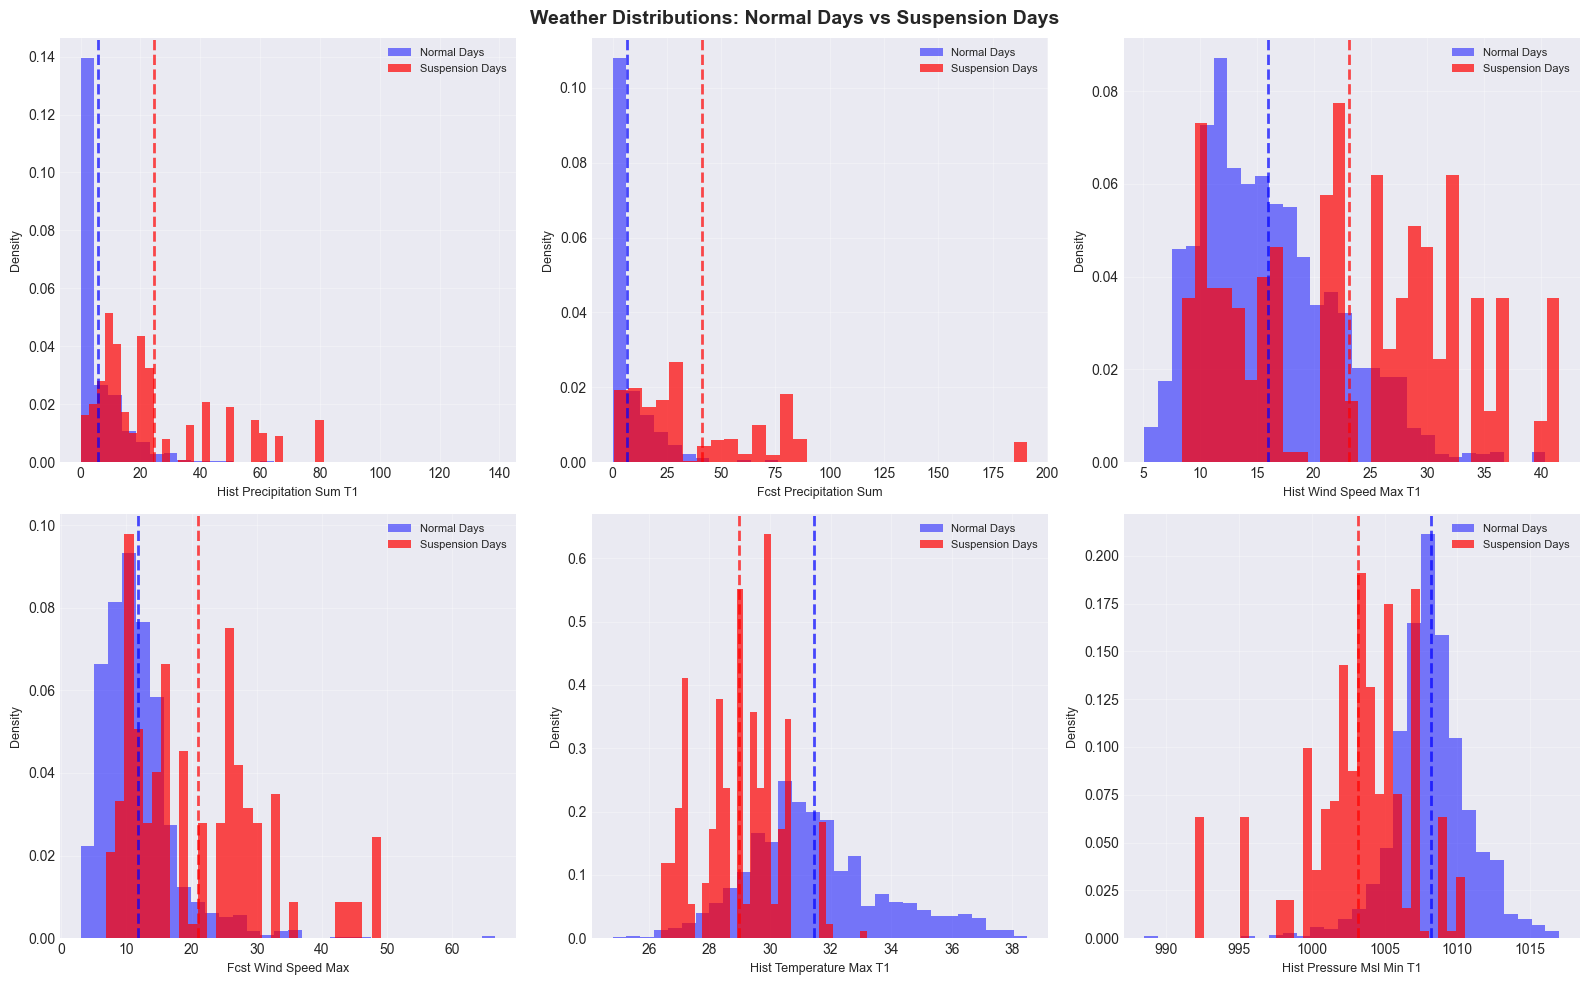

✅ Weather visualization complete


In [8]:
# Cell 3.2: Visualize Weather Conditions
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, feature in enumerate(weather_features):
    ax = axes[idx]
    
    # Histogram comparison
    ax.hist(non_susp[feature].dropna(), bins=30, alpha=0.5, label='Normal Days', color='blue', density=True)
    ax.hist(suspensions[feature].dropna(), bins=30, alpha=0.7, label='Suspension Days', color='red', density=True)
    
    # Add vertical lines for means
    ax.axvline(non_susp[feature].mean(), color='blue', linestyle='--', linewidth=2, alpha=0.7)
    ax.axvline(suspensions[feature].mean(), color='red', linestyle='--', linewidth=2, alpha=0.7)
    
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=9)
    ax.set_ylabel('Density', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Weather Distributions: Normal Days vs Suspension Days', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'weather_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Weather visualization complete")

## Section 4: Announcement Timing Analysis

In [9]:
# Cell 4.1: Early vs Late Announcements
print("="*80)
print("ANNOUNCEMENT TIMING ANALYSIS")
print("="*80)

# Define announcement timing categories based on weather conditions
# Early: Declared with moderate weather (precautionary)
# Late: Declared with severe weather (reactive)

# Calculate severity score
suspensions['precip_severity'] = suspensions['fcst_precipitation_sum'] / suspensions['fcst_precipitation_sum'].quantile(0.75)
suspensions['wind_severity'] = suspensions['fcst_wind_speed_max'] / suspensions['fcst_wind_speed_max'].quantile(0.75)
suspensions['severity_score'] = (suspensions['precip_severity'] + suspensions['wind_severity']) / 2

# Categorize
def categorize_timing(score):
    if score < 0.75:
        return '🟢 Early (Precautionary)'
    elif score < 1.25:
        return '🟡 Normal (Justified)'
    else:
        return '🔴 Late (Reactive)'

suspensions['timing_category'] = suspensions['severity_score'].apply(categorize_timing)

timing_counts = suspensions['timing_category'].value_counts()
print("\nAnnouncement Timing Distribution:")
for category, count in timing_counts.items():
    pct = count / len(suspensions) * 100
    print(f"  {category}: {count} ({pct:.1f}%)")

# LGU-specific timing behavior
print("\n" + "="*80)
print("LGU ANNOUNCEMENT TIMING PROFILES")
print("="*80)

lgu_timing = suspensions.groupby('lgu_id')['timing_category'].value_counts(normalize=True).unstack(fill_value=0) * 100
lgu_timing['LGU_Name'] = lgu_timing.index.map(LOCATION_MAPPING)
lgu_timing = lgu_timing[['LGU_Name', '🟢 Early (Precautionary)', '🟡 Normal (Justified)', '🔴 Late (Reactive)']]
lgu_timing = lgu_timing.sort_values('🟢 Early (Precautionary)', ascending=False)

print("\nLGU Timing Profiles (% of suspensions):")
print(lgu_timing.to_string())

lgu_timing.to_csv(ANALYSIS_DIR / 'lgu_announcement_timing.csv')
print("\n✅ Timing analysis saved")

ANNOUNCEMENT TIMING ANALYSIS

Announcement Timing Distribution:
  🟢 Early (Precautionary): 250 (61.3%)
  🟡 Normal (Justified): 139 (34.1%)
  🔴 Late (Reactive): 19 (4.7%)

LGU ANNOUNCEMENT TIMING PROFILES

LGU Timing Profiles (% of suspensions):
timing_category     LGU_Name  🟢 Early (Precautionary)  🟡 Normal (Justified)  🔴 Late (Reactive)
lgu_id                                                                                        
5                    Malabon                66.666667             27.777778           5.555556
9                    Navotas                65.384615             30.769231           3.846154
14                  San Juan                65.217391             34.782609           0.000000
2                   Caloocan                63.333333             30.000000           6.666667
0                     Manila                62.500000             33.333333           4.166667
1                Quezon City                62.500000             33.333333           4.16

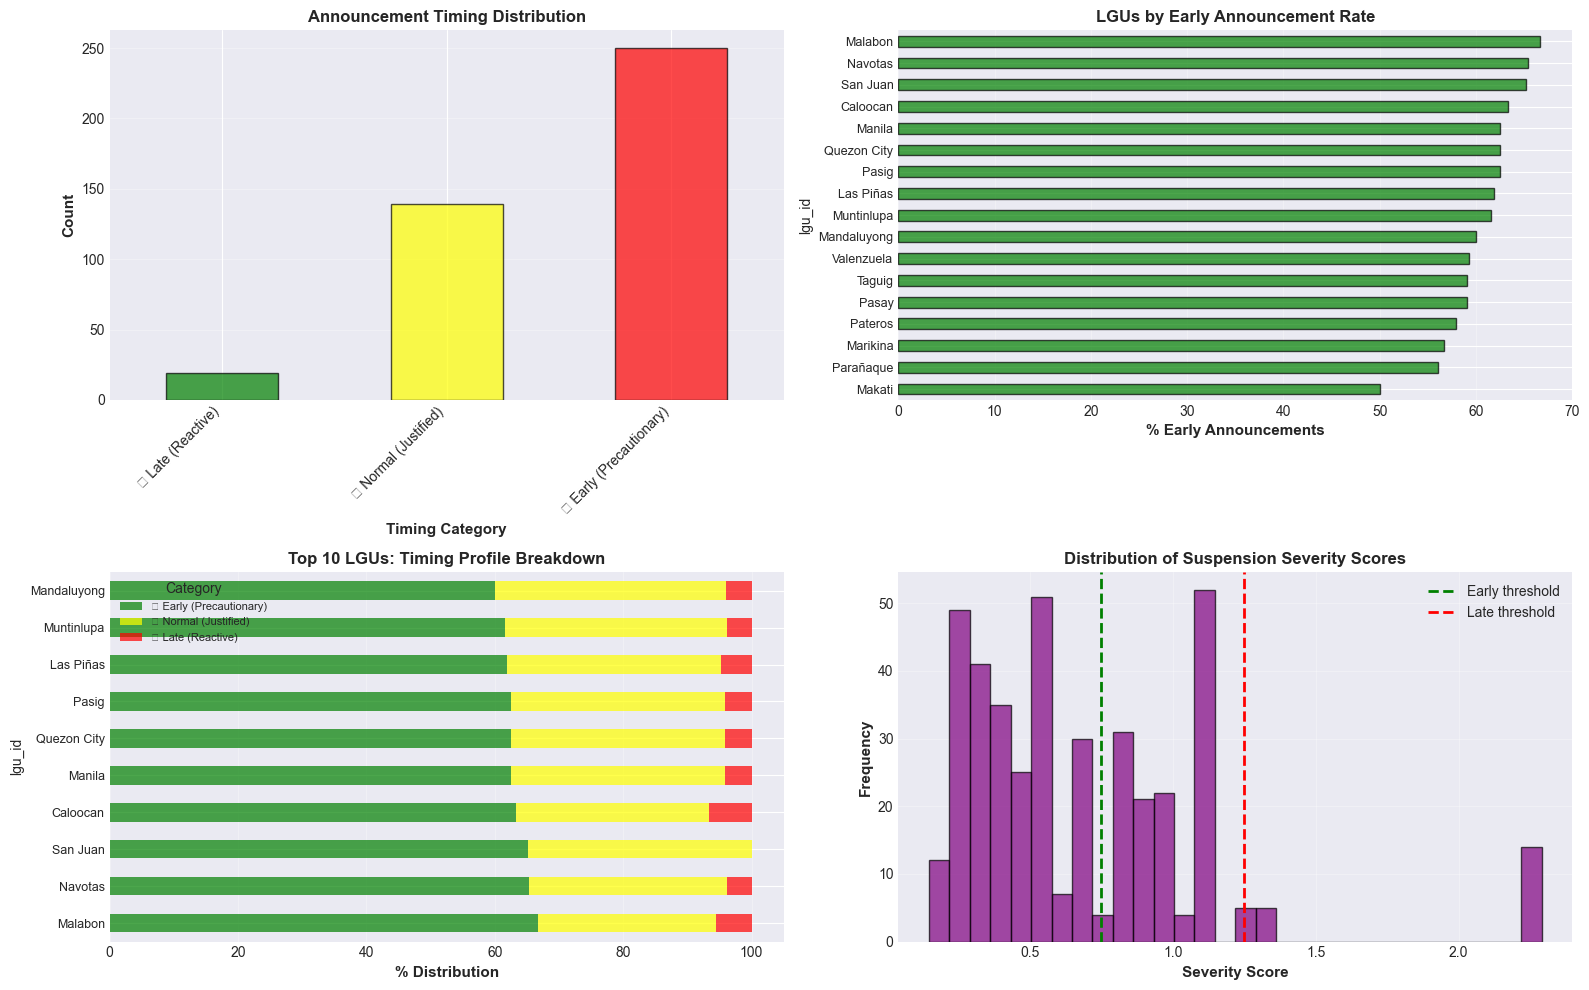

✅ Timing visualization complete


In [10]:
# Cell 4.2: Visualize Announcement Timing
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Overall timing distribution
ax = axes[0, 0]
colors_timing = ['green', 'yellow', 'red']
timing_counts.sort_index().plot(kind='bar', ax=ax, color=colors_timing, alpha=0.7, edgecolor='black')
ax.set_ylabel('Count', fontsize=11, fontweight='bold')
ax.set_xlabel('Timing Category', fontsize=11, fontweight='bold')
ax.set_title('Announcement Timing Distribution', fontsize=12, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# 2. LGU comparison - early announcements
ax = axes[0, 1]
early_sorted = lgu_timing.sort_values('🟢 Early (Precautionary)')
early_sorted['🟢 Early (Precautionary)'].plot(kind='barh', ax=ax, color='green', alpha=0.7, edgecolor='black')
ax.set_yticklabels(early_sorted['LGU_Name'], fontsize=9)
ax.set_xlabel('% Early Announcements', fontsize=11, fontweight='bold')
ax.set_title('LGUs by Early Announcement Rate', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 3. Stacked bar - timing by LGU
ax = axes[1, 0]
timing_data = lgu_timing[['🟢 Early (Precautionary)', '🟡 Normal (Justified)', '🔴 Late (Reactive)']].head(10)
timing_data.plot(kind='barh', stacked=True, ax=ax, color=['green', 'yellow', 'red'], alpha=0.7)
ax.set_yticklabels(lgu_timing.head(10)['LGU_Name'], fontsize=9)
ax.set_xlabel('% Distribution', fontsize=11, fontweight='bold')
ax.set_title('Top 10 LGUs: Timing Profile Breakdown', fontsize=12, fontweight='bold')
ax.legend(title='Category', fontsize=8)
ax.grid(True, alpha=0.3, axis='x')

# 4. Severity score distribution
ax = axes[1, 1]
ax.hist(suspensions['severity_score'], bins=30, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(0.75, color='green', linestyle='--', linewidth=2, label='Early threshold')
ax.axvline(1.25, color='red', linestyle='--', linewidth=2, label='Late threshold')
ax.set_xlabel('Severity Score', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Suspension Severity Scores', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'announcement_timing_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Timing visualization complete")

## Section 5: Geographic Clustering & Patterns

In [11]:
# Cell 5.1: Simultaneous Suspensions (Same-Day Clustering)
print("="*80)
print("GEOGRAPHIC CLUSTERING ANALYSIS")
print("="*80)

# Count LGUs suspending on same day
daily_susp_counts = suspensions.groupby('date')['lgu_id'].count()

print("\nSimultaneous Suspension Patterns:")
print(f"  Days with 1 LGU suspension: {(daily_susp_counts == 1).sum()}")
print(f"  Days with 2-3 LGU suspensions: {((daily_susp_counts >= 2) & (daily_susp_counts <= 3)).sum()}")
print(f"  Days with 4-5 LGU suspensions: {((daily_susp_counts >= 4) & (daily_susp_counts <= 5)).sum()}")
print(f"  Days with 6+ LGU suspensions: {(daily_susp_counts >= 6).sum()}")

# Find biggest cluster day
max_cluster_date = daily_susp_counts.idxmax()
max_cluster_count = daily_susp_counts.max()
cluster_lgus = suspensions[suspensions['date'] == max_cluster_date]['lgu_name'].tolist()

print(f"\n📊 Largest Cluster:")
print(f"   Date: {max_cluster_date.date()}")
print(f"   LGUs: {max_cluster_count}")
print(f"   Affected: {', '.join(cluster_lgus)}")

# Weather on that day
cluster_weather = suspensions[suspensions['date'] == max_cluster_date].iloc[0]
print(f"\n   Weather conditions:")
print(f"     Forecast Precipitation: {cluster_weather['fcst_precipitation_sum']:.1f} mm")
print(f"     Forecast Wind Speed: {cluster_weather['fcst_wind_speed_max']:.1f} km/h")

# LGU co-occurrence matrix
print("\n" + "="*80)
print("LGU CO-SUSPENSION ANALYSIS")
print("="*80)

# Find which LGUs tend to suspend together
suspension_matrix = suspensions.pivot_table(
    index='date', 
    columns='lgu_id', 
    values='suspension_occurred', 
    aggfunc='max', 
    fill_value=0
)

# Calculate co-occurrence
cooccurrence = suspension_matrix.T.dot(suspension_matrix)
np.fill_diagonal(cooccurrence.values, 0)

# Find top pairs
cooccurrence_pairs = []
for i in range(len(cooccurrence)):
    for j in range(i+1, len(cooccurrence)):
        if cooccurrence.iloc[i, j] > 0:
            cooccurrence_pairs.append({
                'LGU1': LOCATION_MAPPING[cooccurrence.index[i]],
                'LGU2': LOCATION_MAPPING[cooccurrence.columns[j]],
                'Co_Suspensions': int(cooccurrence.iloc[i, j])
            })

cooccurrence_df = pd.DataFrame(cooccurrence_pairs).sort_values('Co_Suspensions', ascending=False)

print("\nTop 10 LGU Pairs (Most Frequently Suspend Together):")
print(cooccurrence_df.head(10).to_string(index=False))

cooccurrence_df.to_csv(ANALYSIS_DIR / 'lgu_cooccurrence.csv', index=False)
print("\n✅ Geographic clustering analysis saved")

GEOGRAPHIC CLUSTERING ANALYSIS

Simultaneous Suspension Patterns:
  Days with 1 LGU suspension: 10
  Days with 2-3 LGU suspensions: 2
  Days with 4-5 LGU suspensions: 10
  Days with 6+ LGU suspensions: 26

📊 Largest Cluster:
   Date: 2023-08-31
   LGUs: 17
   Affected: Manila, Quezon City, Caloocan, Las Piñas, Makati, Malabon, Mandaluyong, Marikina, Muntinlupa, Navotas, Parañaque, Pasay, Pasig, Pateros, San Juan, Taguig, Valenzuela

   Weather conditions:
     Forecast Precipitation: 24.9 mm
     Forecast Wind Speed: 14.6 km/h

LGU CO-SUSPENSION ANALYSIS

Top 10 LGU Pairs (Most Frequently Suspend Together):
    LGU1       LGU2  Co_Suspensions
Caloocan    Malabon              28
 Malabon   Marikina              26
 Malabon    Navotas              26
Caloocan   Marikina              25
 Malabon  Parañaque              25
  Manila   Caloocan              24
 Malabon Muntinlupa              24
Marikina Valenzuela              24
Caloocan Valenzuela              24
Caloocan   San Juan      

## Section 6: Weather Correlation & Feature Relationships

In [12]:
# Cell 6.1: Weather Feature Correlation Analysis
print("="*80)
print("WEATHER FEATURE CORRELATION ANALYSIS")
print("="*80)

# Select all weather features for correlation
all_weather_features = [col for col in all_data.columns if any(x in col for x in 
    ['precipitation', 'temperature', 'wind', 'pressure', 'humidity', 'cloud', 'dew'])]

# Calculate correlation with suspension_occurred
correlations = all_data[all_weather_features + ['suspension_occurred']].corr()['suspension_occurred'].drop('suspension_occurred')
correlations = correlations.sort_values(ascending=False)

print("\nTop 15 Features Correlated with Suspension:")
print("="*80)
for feat, corr in correlations.head(15).items():
    direction = "↑ Positive" if corr > 0 else "↓ Negative"
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.2 else "Weak"
    print(f"  {feat:45} : {corr:+.4f} ({direction}, {strength})")

print("\nBottom 15 Features (Negatively Correlated):")
print("="*80)
for feat, corr in correlations.tail(15).items():
    direction = "↑ Positive" if corr > 0 else "↓ Negative"
    strength = "Strong" if abs(corr) > 0.3 else "Moderate" if abs(corr) > 0.2 else "Weak"
    print(f"  {feat:45} : {corr:+.4f} ({direction}, {strength})")

# Save correlation results
correlations.to_csv(ANALYSIS_DIR / 'feature_correlations.csv', header=['Correlation'])
print("\n✅ Correlation analysis saved")

WEATHER FEATURE CORRELATION ANALYSIS

Top 15 Features Correlated with Suspension:
  fcst_precipitation_sum                        : +0.3861 (↑ Positive, Strong)
  fcst_wind_gusts_max                           : +0.2543 (↑ Positive, Moderate)
  hist_precipitation_sum_t1                     : +0.2517 (↑ Positive, Moderate)
  fcst_precipitation_hours                      : +0.2388 (↑ Positive, Moderate)
  fcst_wind_speed_max                           : +0.2240 (↑ Positive, Moderate)
  fcst_relative_humidity_mean                   : +0.2126 (↑ Positive, Moderate)
  hist_wind_speed_max_t1                        : +0.1687 (↑ Positive, Weak)
  hist_wind_gusts_max_t1                        : +0.1576 (↑ Positive, Weak)
  hist_relative_humidity_mean_t1                : +0.1420 (↑ Positive, Weak)
  fcst_dew_point_mean                           : +0.1308 (↑ Positive, Weak)
  hist_wind_max_7d                              : +0.1195 (↑ Positive, Weak)
  hist_dew_point_mean_t1                        :

Generating correlation heatmap...


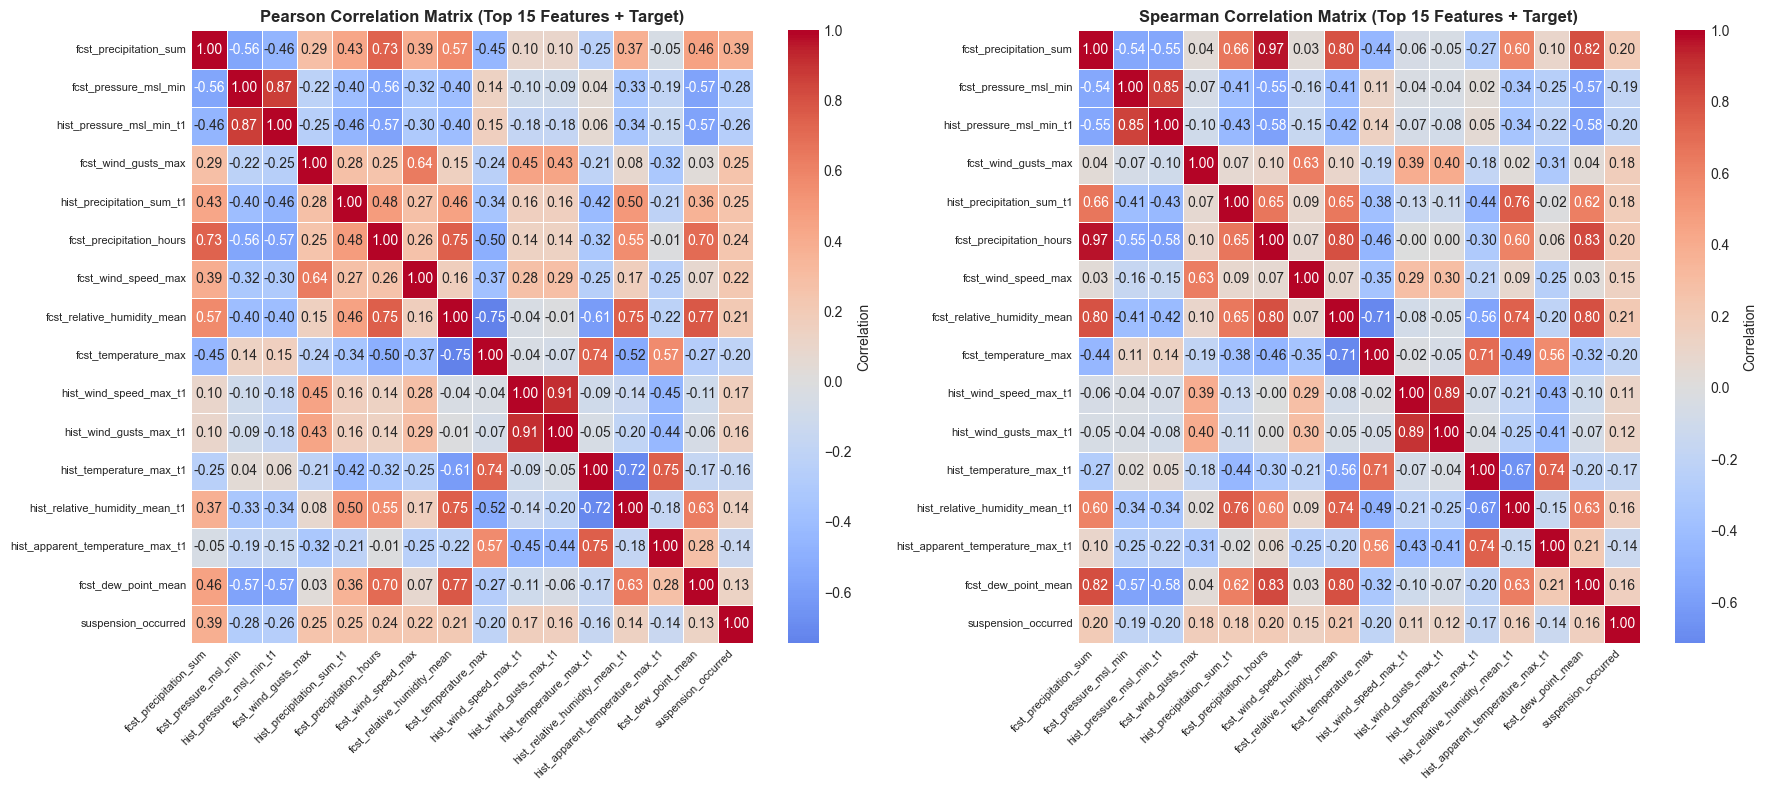

✅ Heatmap visualization complete


In [13]:
# Cell 6.2: Correlation Heatmap
from scipy.stats import spearmanr

print("Generating correlation heatmap...")

# Select key features for heatmap (top correlated + target)
top_features = correlations.abs().sort_values(ascending=False).head(15).index.tolist()
heatmap_data = all_data[top_features + ['suspension_occurred']].corr()

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Pearson correlation
ax = axes[0]
sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=ax, cbar_kws={'label': 'Correlation'}, linewidths=0.5)
ax.set_title('Pearson Correlation Matrix (Top 15 Features + Target)', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)

# Spearman correlation (non-linear relationships)
ax = axes[1]
spearman_corr = all_data[top_features + ['suspension_occurred']].corr(method='spearman')
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            ax=ax, cbar_kws={'label': 'Correlation'}, linewidths=0.5)
ax.set_title('Spearman Correlation Matrix (Top 15 Features + Target)', fontsize=12, fontweight='bold')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=8)
plt.setp(ax.yaxis.get_majorticklabels(), rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'correlation_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Heatmap visualization complete")

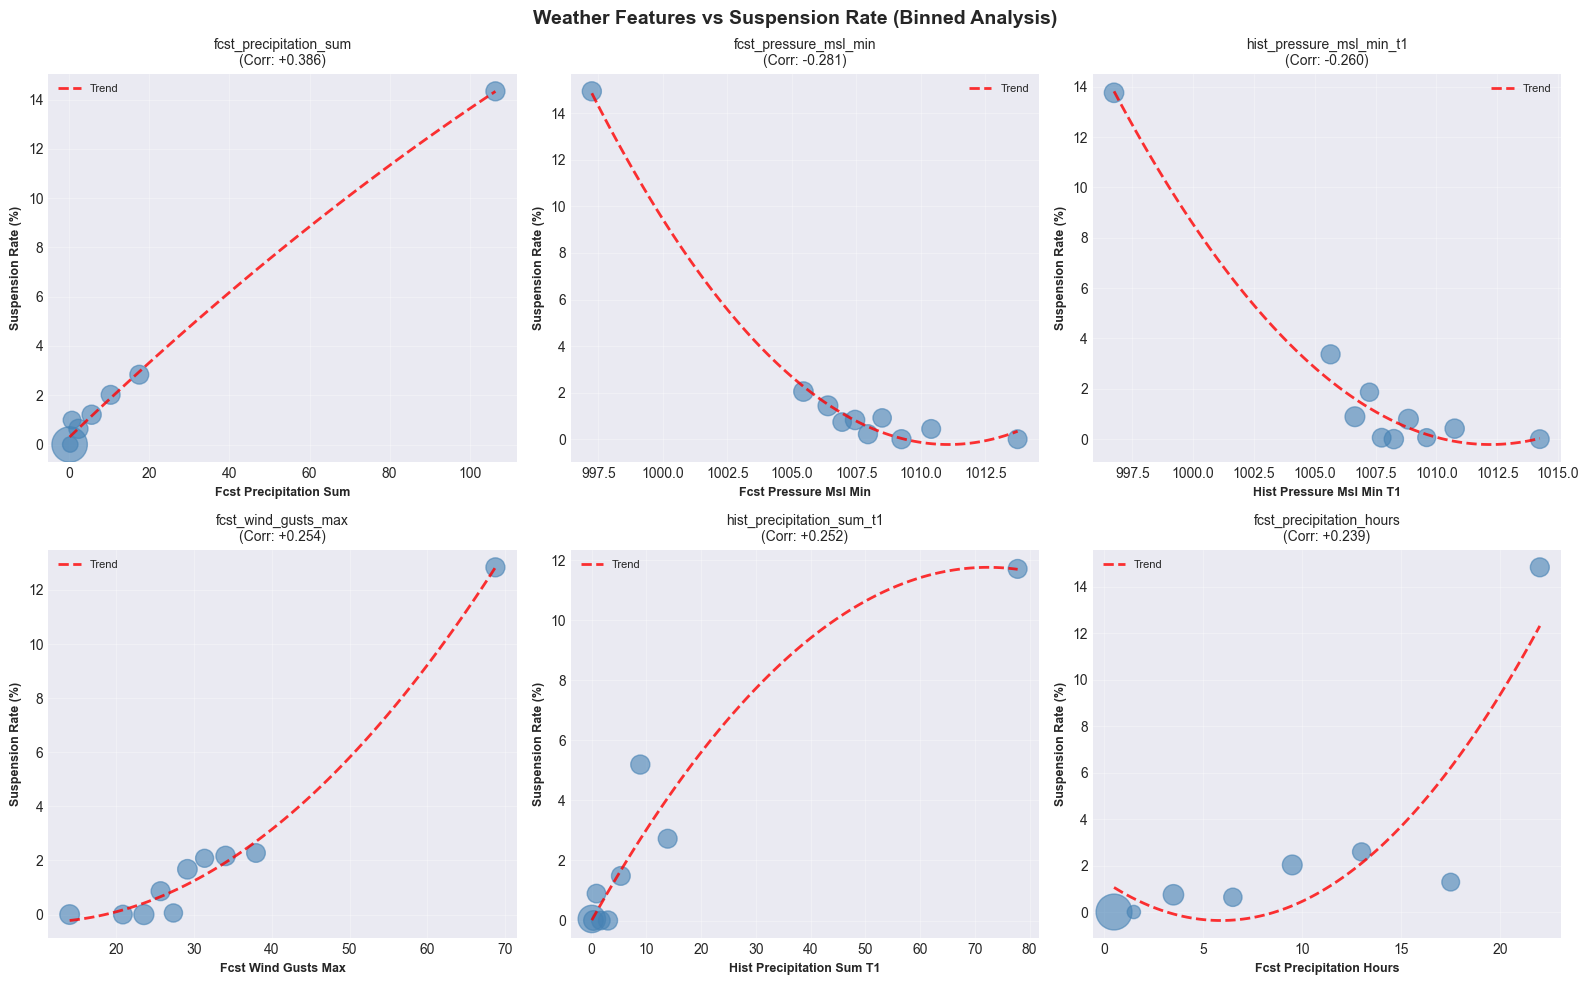

✅ Scatter plot analysis complete


In [14]:
# Cell 6.3: Scatter Plots - Key Weather vs Suspension Rate
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Top 6 most correlated features
top_6_features = correlations.abs().sort_values(ascending=False).head(6).index.tolist()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    
    # Create bins for the feature
    feature_data = all_data[[feature, 'suspension_occurred']].dropna()
    feature_data['feature_bin'] = pd.qcut(feature_data[feature], q=10, duplicates='drop')
    
    # Calculate suspension rate per bin
    bin_stats = feature_data.groupby('feature_bin')['suspension_occurred'].agg(['mean', 'count'])
    bin_centers = [interval.mid for interval in bin_stats.index]
    
    # Scatter + trend line
    ax.scatter(bin_centers, bin_stats['mean'] * 100, s=bin_stats['count']/10, alpha=0.6, c='steelblue')
    
    # Add polynomial fit
    z = np.polyfit(bin_centers, bin_stats['mean'] * 100, 2)
    p = np.poly1d(z)
    x_smooth = np.linspace(min(bin_centers), max(bin_centers), 100)
    ax.plot(x_smooth, p(x_smooth), "r--", linewidth=2, alpha=0.8, label='Trend')
    
    ax.set_xlabel(feature.replace('_', ' ').title(), fontsize=9, fontweight='bold')
    ax.set_ylabel('Suspension Rate (%)', fontsize=9, fontweight='bold')
    ax.set_title(f'{feature}\n(Corr: {correlations[feature]:+.3f})', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle('Weather Features vs Suspension Rate (Binned Analysis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'weather_vs_suspension_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Scatter plot analysis complete")

## Section 7: Flood Risk Patterns by LGU

In [16]:
# Cell 7.1: Flood Risk Score Analysis by LGU
print("="*80)
print("FLOOD RISK PATTERNS BY LGU")
print("="*80)

# Check if flood risk columns exist
flood_cols = [col for col in all_data.columns if 'flood' in col.lower()]
print(f"\nFlood risk columns available: {flood_cols}")

if len(flood_cols) > 0:
    # Separate numeric and categorical flood columns
    numeric_flood_cols = [col for col in flood_cols if all_data[col].dtype in ['float64', 'int64', 'float32', 'int32']]
    categorical_flood_cols = [col for col in flood_cols if col not in numeric_flood_cols]
    
    print(f"  Numeric columns: {numeric_flood_cols}")
    print(f"  Categorical columns: {categorical_flood_cols}")
    
    # Get mean flood risk score
    if 'mean_flood_risk_score' in numeric_flood_cols:
        main_flood_col = 'mean_flood_risk_score'
    elif len(numeric_flood_cols) > 0:
        main_flood_col = numeric_flood_cols[0]
    else:
        print("\n⚠️  No numeric flood risk columns found")
        main_flood_col = None
    
    if main_flood_col:
        # Analyze mean flood risk by LGU (numeric columns only)
        if len(numeric_flood_cols) > 0:
            lgu_flood_stats = all_data.groupby('lgu_id')[numeric_flood_cols].agg(['mean', 'std', 'min', 'max'])
            lgu_flood_stats['LGU_Name'] = lgu_flood_stats.index.map(LOCATION_MAPPING)
        
        lgu_flood_summary = all_data.groupby('lgu_id').agg({
            main_flood_col: ['mean', 'std'],
            'suspension_occurred': 'sum'
        })
        lgu_flood_summary.columns = ['Avg_Flood_Risk', 'Std_Flood_Risk', 'Total_Suspensions']
        lgu_flood_summary['LGU_Name'] = lgu_flood_summary.index.map(LOCATION_MAPPING)
        lgu_flood_summary = lgu_flood_summary.sort_values('Avg_Flood_Risk', ascending=False)
        
        print("\nLGU Flood Risk Rankings:")
        print("="*80)
        print(lgu_flood_summary[['LGU_Name', 'Avg_Flood_Risk', 'Std_Flood_Risk', 'Total_Suspensions']].to_string())
        
        # Correlation between flood risk and suspension rate
        lgu_combined = lgu_stats.merge(lgu_flood_summary, left_index=True, right_index=True, suffixes=('', '_flood'))
        corr_flood_susp = lgu_combined['Avg_Flood_Risk'].corr(lgu_combined['Suspension_Rate_%'])
        
        print(f"\n📊 Correlation: Flood Risk vs Suspension Rate = {corr_flood_susp:+.4f}")
        
        # Suspensions by flood risk category (if categorical column exists)
        if 'flood_risk_classification' in all_data.columns:
            flood_cat_stats = all_data.groupby('flood_risk_classification')['suspension_occurred'].agg(['sum', 'count', 'mean'])
            flood_cat_stats.columns = ['Total_Suspensions', 'Total_Days', 'Suspension_Rate']
            flood_cat_stats['Suspension_Rate_%'] = flood_cat_stats['Suspension_Rate'] * 100
            
            print("\nSuspensions by Flood Risk Category:")
            print("="*80)
            print(flood_cat_stats[['Total_Suspensions', 'Total_Days', 'Suspension_Rate_%']].to_string())
        
        lgu_flood_summary.to_csv(ANALYSIS_DIR / 'lgu_flood_risk_analysis.csv')
        print("\n✅ Flood risk analysis saved")
else:
    print("\n⚠️  No flood risk columns found in dataset")

FLOOD RISK PATTERNS BY LGU

Flood risk columns available: ['mean_flood_risk_score', 'flood_risk_classification']
  Numeric columns: ['mean_flood_risk_score']
  Categorical columns: ['flood_risk_classification']

LGU Flood Risk Rankings:
           LGU_Name  Avg_Flood_Risk  Std_Flood_Risk  Total_Suspensions
lgu_id                                                                
0            Manila          1.5552             0.0                 24
1       Quezon City          0.9184             0.0                 24
2          Caloocan          0.4302             0.0                 30
15           Taguig          0.3759             0.0                 22
6       Mandaluyong          0.0027             0.0                 25
12            Pasig         -0.2418             0.0                 24
4            Makati         -0.3430             0.0                  4
7          Marikina         -0.4456             0.0                 30
5           Malabon         -0.6497             0.0  

KeyError: 'Total_Suspensions_x'

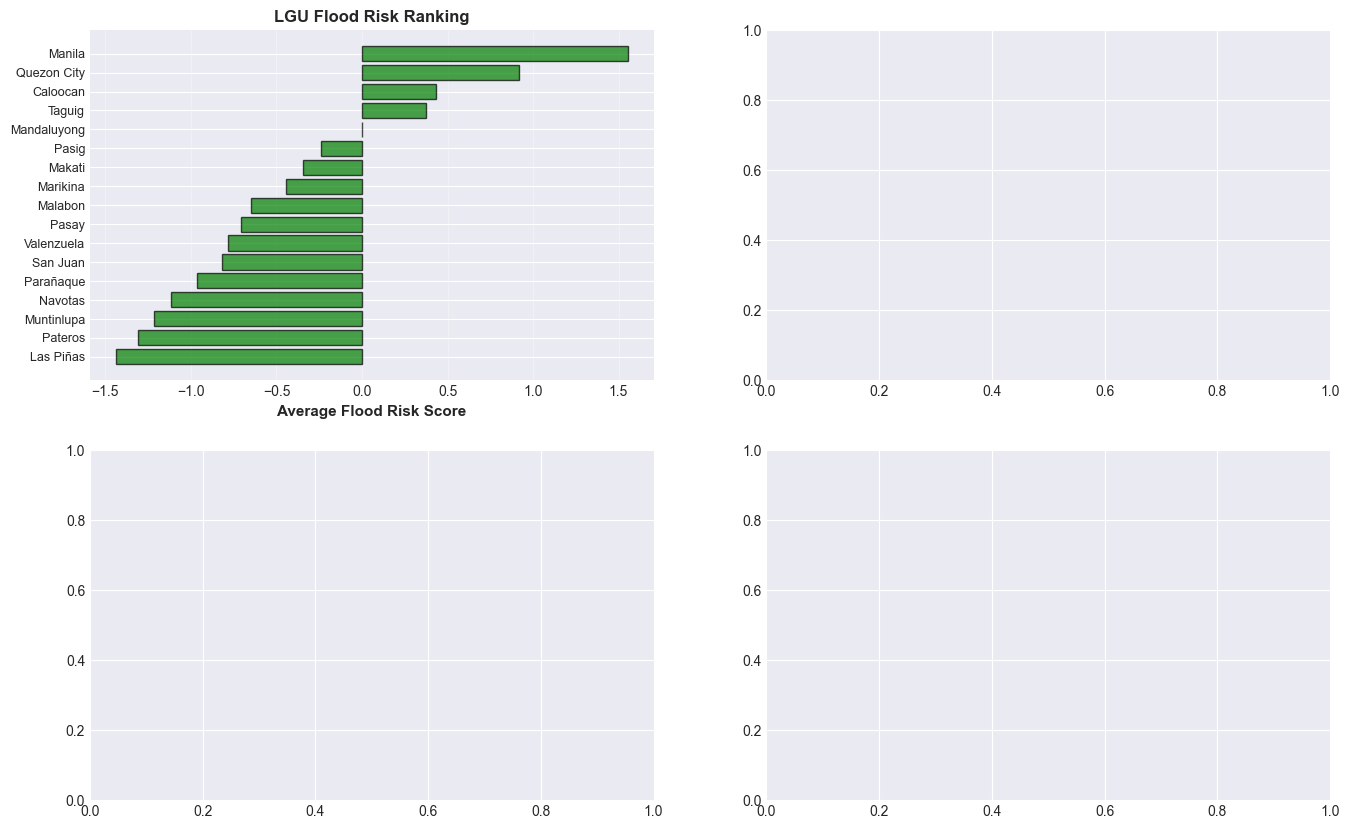

In [ ]:
# Cell 7.2: Visualize Flood Risk Patterns
if len(flood_cols) > 0 and main_flood_col:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Dynamically find the correct column names after merge
    lgu_name_col = 'LGU_Name' if 'LGU_Name' in lgu_combined.columns else 'LGU_Name_flood'
    total_susp_col = 'Total_Suspensions' if 'Total_Suspensions' in lgu_combined.columns else 'Total_Suspensions_flood'
    
    # 1. Flood risk by LGU (bar chart)
    ax = axes[0, 0]
    flood_sorted = lgu_flood_summary.sort_values('Avg_Flood_Risk')
    colors_flood = ['red' if x > 3.0 else 'orange' if x > 2.0 else 'green' for x in flood_sorted['Avg_Flood_Risk']]
    ax.barh(range(len(flood_sorted)), flood_sorted['Avg_Flood_Risk'], color=colors_flood, alpha=0.7, edgecolor='black')
    ax.set_yticks(range(len(flood_sorted)))
    ax.set_yticklabels(flood_sorted['LGU_Name'], fontsize=9)
    ax.set_xlabel('Average Flood Risk Score', fontsize=11, fontweight='bold')
    ax.set_title('LGU Flood Risk Ranking', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # 2. Flood risk vs suspension rate (scatter)
    ax = axes[0, 1]
    scatter = ax.scatter(lgu_combined['Avg_Flood_Risk'], lgu_combined['Suspension_Rate_%'],
                        s=lgu_combined[total_susp_col]*20, alpha=0.6, 
                        c=lgu_combined['Suspension_Rate_%'], cmap='RdYlGn_r', edgecolors='black')
    ax.set_xlabel('Average Flood Risk Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Suspension Rate (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'Flood Risk vs Suspension Rate (Corr: {corr_flood_susp:+.3f})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(lgu_combined['Avg_Flood_Risk'], lgu_combined['Suspension_Rate_%'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(lgu_combined['Avg_Flood_Risk'].min(), lgu_combined['Avg_Flood_Risk'].max(), 100)
    ax.plot(x_line, p(x_line), "r--", linewidth=2, alpha=0.7, label=f'Trend (R={corr_flood_susp:.3f})')
    ax.legend()
    
    # Annotate outliers - use correct column name
    for _, row in lgu_combined.iterrows():
        if row['Suspension_Rate_%'] > 2.0 or row['Suspension_Rate_%'] < 0.3:
            ax.annotate(row[lgu_name_col], (row['Avg_Flood_Risk'], row['Suspension_Rate_%']),
                       fontsize=8, ha='center', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Suspension Rate (%)', fontsize=10)
    
    # 3. Flood risk distribution
    ax = axes[1, 0]
    ax.hist(all_data[main_flood_col].dropna(), bins=40, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(all_data[main_flood_col].mean(), color='red', linestyle='--', linewidth=2, 
              label=f'Mean: {all_data[main_flood_col].mean():.2f}')
    ax.axvline(all_data[main_flood_col].median(), color='orange', linestyle='--', linewidth=2,
              label=f'Median: {all_data[main_flood_col].median():.2f}')
    ax.set_xlabel('Flood Risk Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title('Distribution of Flood Risk Scores', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Flood risk on suspension days vs normal days
    ax = axes[1, 1]
    susp_flood = suspensions[main_flood_col].dropna()
    normal_flood = non_susp[main_flood_col].dropna()
    
    ax.hist(normal_flood, bins=30, alpha=0.5, label='Normal Days', color='blue', density=True)
    ax.hist(susp_flood, bins=30, alpha=0.7, label='Suspension Days', color='red', density=True)
    ax.axvline(normal_flood.mean(), color='blue', linestyle='--', linewidth=2, alpha=0.7)
    ax.axvline(susp_flood.mean(), color='red', linestyle='--', linewidth=2, alpha=0.7)
    ax.set_xlabel('Flood Risk Score', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title('Flood Risk: Suspension vs Normal Days', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ANALYSIS_DIR / 'flood_risk_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✅ Flood risk visualization complete")
else:
    print("⚠️  Skipping flood risk visualization")


## Section 8: Statistical Hypothesis Testing

In [ ]:
# Cell 8.1: Chi-Square Test for LGU Independence
from scipy.stats import chi2_contingency, mannwhitneyu, ks_2samp

print("="*80)
print("STATISTICAL HYPOTHESIS TESTING")
print("="*80)

# Test 1: Chi-Square Test - Are LGU suspension patterns independent?
print("\n" + "="*80)
print("TEST 1: Chi-Square Test for LGU Independence")
print("="*80)
print("H0: LGU suspension decisions are independent (no LGU-specific patterns)")
print("H1: LGUs have significantly different suspension patterns")

# Create contingency table: LGU vs Suspension
contingency_table = pd.crosstab(all_data['lgu_id'], all_data['suspension_occurred'])
print(f"\nContingency Table Shape: {contingency_table.shape}")
print(contingency_table)

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nTest Results:")
print(f"  Chi-Square Statistic: {chi2:.4f}")
print(f"  P-value: {p_value:.4e}")
print(f"  Degrees of Freedom: {dof}")
print(f"  Expected Frequencies (first 5x2):")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns).head())

alpha = 0.05
if p_value < alpha:
    print(f"\n✅ REJECT H0 (p < {alpha}): LGUs have SIGNIFICANTLY DIFFERENT suspension patterns")
    print("   → Each LGU has its own decision-making behavior")
else:
    print(f"\n❌ FAIL TO REJECT H0 (p >= {alpha}): LGUs suspension patterns are similar")

# Calculate Cramér's V (effect size)
n = contingency_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
print(f"\n📊 Cramér's V (Effect Size): {cramers_v:.4f}")
if cramers_v > 0.5:
    print("   → Strong association between LGU and suspension behavior")
elif cramers_v > 0.3:
    print("   → Moderate association")
elif cramers_v > 0.1:
    print("   → Weak association")
else:
    print("   → Very weak association")

In [ ]:
# Cell 8.2: Mann-Whitney U Test - Weather Differences
print("\n" + "="*80)
print("TEST 2: Mann-Whitney U Test - Weather on Suspension vs Normal Days")
print("="*80)
print("H0: Weather conditions are the same on suspension and normal days")
print("H1: Weather conditions differ significantly between suspension and normal days")

# Test for key weather features
test_features = ['fcst_precipitation_sum', 'fcst_wind_speed_max', 'hist_temperature_max_t1']

mw_results = []
for feature in test_features:
    susp_values = suspensions[feature].dropna()
    normal_values = non_susp[feature].dropna()
    
    # Perform Mann-Whitney U test (non-parametric)
    statistic, p_value = mannwhitneyu(susp_values, normal_values, alternative='two-sided')
    
    # Calculate effect size (rank-biserial correlation)
    n1, n2 = len(susp_values), len(normal_values)
    r = 1 - (2*statistic) / (n1 * n2)  # rank-biserial correlation
    
    result = {
        'Feature': feature,
        'Suspension_Median': susp_values.median(),
        'Normal_Median': normal_values.median(),
        'U_Statistic': statistic,
        'P_Value': p_value,
        'Effect_Size_r': abs(r),
        'Significant': 'Yes ✓' if p_value < 0.05 else 'No ✗'
    }
    mw_results.append(result)
    
    print(f"\n{feature}:")
    print(f"  Suspension days median: {susp_values.median():.2f}")
    print(f"  Normal days median: {normal_values.median():.2f}")
    print(f"  U-statistic: {statistic:.2f}")
    print(f"  P-value: {p_value:.4e}")
    print(f"  Effect size (r): {abs(r):.4f}")
    if p_value < 0.05:
        print(f"  ✅ SIGNIFICANT DIFFERENCE (p < 0.05)")
    else:
        print(f"  ❌ NO SIGNIFICANT DIFFERENCE (p >= 0.05)")

mw_df = pd.DataFrame(mw_results)
mw_df.to_csv(ANALYSIS_DIR / 'mann_whitney_tests.csv', index=False)
print("\n✅ Mann-Whitney test results saved")

In [ ]:
# Cell 8.3: Kolmogorov-Smirnov Test - Distribution Comparison
print("\n" + "="*80)
print("TEST 3: Kolmogorov-Smirnov Test - Distribution Similarity")
print("="*80)
print("H0: Weather distributions are the same for suspension and normal days")
print("H1: Weather distributions differ significantly")

ks_results = []
for feature in test_features:
    susp_values = suspensions[feature].dropna()
    normal_values = non_susp[feature].dropna()
    
    # Perform KS test
    statistic, p_value = ks_2samp(susp_values, normal_values)
    
    result = {
        'Feature': feature,
        'KS_Statistic': statistic,
        'P_Value': p_value,
        'Significant': 'Yes ✓' if p_value < 0.05 else 'No ✗'
    }
    ks_results.append(result)
    
    print(f"\n{feature}:")
    print(f"  KS Statistic: {statistic:.4f}")
    print(f"  P-value: {p_value:.4e}")
    if p_value < 0.05:
        print(f"  ✅ DISTRIBUTIONS ARE SIGNIFICANTLY DIFFERENT")
    else:
        print(f"  ❌ DISTRIBUTIONS ARE SIMILAR")

ks_df = pd.DataFrame(ks_results)
ks_df.to_csv(ANALYSIS_DIR / 'ks_tests.csv', index=False)
print("\n✅ KS test results saved")

In [ ]:
# Cell 8.4: Statistical Tests Summary Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Chi-square residuals (standardized)
ax = axes[0, 0]
residuals = (contingency_table.values - expected) / np.sqrt(expected)
sns.heatmap(residuals, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax,
           yticklabels=[LOCATION_MAPPING[i] for i in contingency_table.index],
           xticklabels=['No Suspension', 'Suspension'])
ax.set_title('Chi-Square Standardized Residuals\n(Red = More suspensions than expected)', fontsize=12, fontweight='bold')
ax.set_ylabel('LGU', fontsize=11, fontweight='bold')

# 2. Mann-Whitney effect sizes
ax = axes[0, 1]
mw_df_sorted = mw_df.sort_values('Effect_Size_r')
colors_sig = ['green' if s == 'Yes ✓' else 'red' for s in mw_df_sorted['Significant']]
ax.barh(range(len(mw_df_sorted)), mw_df_sorted['Effect_Size_r'], color=colors_sig, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(mw_df_sorted)))
ax.set_yticklabels([f.replace('_', ' ').title() for f in mw_df_sorted['Feature']], fontsize=9)
ax.set_xlabel('Effect Size (Rank-Biserial r)', fontsize=11, fontweight='bold')
ax.set_title('Mann-Whitney U Test Effect Sizes\n(Green = Significant, Red = Not significant)', fontsize=12, fontweight='bold')
ax.axvline(0.5, color='black', linestyle='--', linewidth=1, alpha=0.5, label='Large effect (r=0.5)')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 3. P-values comparison
ax = axes[1, 0]
test_comparison = pd.DataFrame({
    'Feature': test_features,
    'Mann-Whitney p': mw_df['P_Value'].values,
    'KS-Test p': ks_df['P_Value'].values
})

x = np.arange(len(test_features))
width = 0.35
ax.bar(x - width/2, -np.log10(test_comparison['Mann-Whitney p']), width, label='Mann-Whitney', alpha=0.7)
ax.bar(x + width/2, -np.log10(test_comparison['KS-Test p']), width, label='KS-Test', alpha=0.7)
ax.axhline(-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05 threshold')
ax.set_ylabel('-log10(p-value)', fontsize=11, fontweight='bold')
ax.set_xlabel('Feature', fontsize=11, fontweight='bold')
ax.set_title('Statistical Test P-Values (Higher = More Significant)', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f.replace('_', '\n').title() for f in test_features], fontsize=8)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 4. LGU suspension rate with confidence intervals
ax = axes[1, 1]
lgu_ci = all_data.groupby('lgu_id')['suspension_occurred'].agg(['mean', 'sem'])
lgu_ci['LGU_Name'] = lgu_ci.index.map(LOCATION_MAPPING)
lgu_ci = lgu_ci.sort_values('mean')
lgu_ci['ci_lower'] = lgu_ci['mean'] - 1.96 * lgu_ci['sem']
lgu_ci['ci_upper'] = lgu_ci['mean'] + 1.96 * lgu_ci['sem']

ax.errorbar(lgu_ci['mean']*100, range(len(lgu_ci)), 
           xerr=[(lgu_ci['mean'] - lgu_ci['ci_lower'])*100, (lgu_ci['ci_upper'] - lgu_ci['mean'])*100],
           fmt='o', markersize=8, capsize=5, capthick=2, alpha=0.7)
ax.set_yticks(range(len(lgu_ci)))
ax.set_yticklabels(lgu_ci['LGU_Name'], fontsize=9)
ax.set_xlabel('Suspension Rate (%) with 95% CI', fontsize=11, fontweight='bold')
ax.set_title('LGU Suspension Rates with Confidence Intervals', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'statistical_tests_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Statistical test visualizations complete")

## Section 9: Advanced Timing Analysis with Adjusted Thresholds

In [ ]:
# Cell 9.1: Multi-Threshold Timing Analysis
print("="*80)
print("ADVANCED TIMING ANALYSIS - Multiple Threshold Schemes")
print("="*80)

# Test different threshold schemes
threshold_schemes = {
    'Conservative (0.5, 1.5)': {'early': 0.5, 'late': 1.5},
    'Moderate (0.75, 1.25)': {'early': 0.75, 'late': 1.25},  # Original
    'Aggressive (1.0, 1.5)': {'early': 1.0, 'late': 1.5},
}

timing_comparison = []

for scheme_name, thresholds in threshold_schemes.items():
    def categorize_timing_custom(score):
        if score < thresholds['early']:
            return 'Early'
        elif score < thresholds['late']:
            return 'Normal'
        else:
            return 'Late'
    
    suspensions[f'timing_{scheme_name}'] = suspensions['severity_score'].apply(categorize_timing_custom)
    
    counts = suspensions[f'timing_{scheme_name}'].value_counts()
    timing_comparison.append({
        'Scheme': scheme_name,
        'Early_%': (counts.get('Early', 0) / len(suspensions) * 100),
        'Normal_%': (counts.get('Normal', 0) / len(suspensions) * 100),
        'Late_%': (counts.get('Late', 0) / len(suspensions) * 100),
    })

timing_comp_df = pd.DataFrame(timing_comparison)

print("\nTiming Classification Sensitivity Analysis:")
print("="*80)
print(timing_comp_df.to_string(index=False))

# Identify "trigger-happy" behavior with different thresholds
print("\n" + "="*80)
print("TRIGGER-HAPPY IDENTIFICATION ACROSS THRESHOLDS")
print("="*80)

for scheme_name in threshold_schemes.keys():
    col_name = f'timing_{scheme_name}'
    early_by_lgu = suspensions.groupby('lgu_id')[col_name].apply(lambda x: (x == 'Early').sum() / len(x) * 100)
    early_by_lgu = early_by_lgu.sort_values(ascending=False)
    
    print(f"\n{scheme_name}:")
    print("  Top 5 Trigger-Happy LGUs:")
    for lgu_id, pct in early_by_lgu.head(5).items():
        print(f"    {LOCATION_MAPPING[lgu_id]:15} : {pct:5.1f}% early announcements")

timing_comp_df.to_csv(ANALYSIS_DIR / 'timing_threshold_sensitivity.csv', index=False)
print("\n✅ Threshold sensitivity analysis saved")

In [ ]:
# Cell 9.2: Visualize Threshold Sensitivity
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Stacked bar comparison of threshold schemes
ax = axes[0, 0]
timing_comp_df.set_index('Scheme')[['Early_%', 'Normal_%', 'Late_%']].plot(
    kind='barh', stacked=True, ax=ax, color=['green', 'yellow', 'red'], alpha=0.7)
ax.set_xlabel('Percentage of Suspensions', fontsize=11, fontweight='bold')
ax.set_title('Timing Classification Across Threshold Schemes', fontsize=12, fontweight='bold')
ax.legend(title='Category', fontsize=9)
ax.grid(True, alpha=0.3, axis='x')

# 2. Severity score distribution with multiple thresholds
ax = axes[0, 1]
ax.hist(suspensions['severity_score'], bins=40, color='steelblue', alpha=0.7, edgecolor='black')
colors_thresh = ['green', 'orange', 'red']
for idx, (scheme_name, thresholds) in enumerate(threshold_schemes.items()):
    ax.axvline(thresholds['early'], color=colors_thresh[idx], linestyle='--', linewidth=2, 
              alpha=0.7, label=f"{scheme_name.split('(')[0].strip()} Early")
    ax.axvline(thresholds['late'], color=colors_thresh[idx], linestyle=':', linewidth=2, 
              alpha=0.7, label=f"{scheme_name.split('(')[0].strip()} Late")
ax.set_xlabel('Severity Score', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Severity Distribution with Multiple Threshold Schemes', fontsize=12, fontweight='bold')
ax.legend(fontsize=7, loc='upper right')
ax.grid(True, alpha=0.3)

# 3. LGU "trigger-happy" rankings across schemes
ax = axes[1, 0]
# Calculate early % for each LGU across original scheme
early_pcts = []
for lgu_id in sorted(all_data['lgu_id'].unique()):
    lgu_susp = suspensions[suspensions['lgu_id'] == lgu_id]
    if len(lgu_susp) > 0:
        early_pct = (lgu_susp['timing_category'] == '🟢 Early (Precautionary)').sum() / len(lgu_susp) * 100
        early_pcts.append({'LGU': LOCATION_MAPPING[lgu_id], 'Early_%': early_pct})

early_df = pd.DataFrame(early_pcts).sort_values('Early_%')
ax.barh(range(len(early_df)), early_df['Early_%'], color='green', alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(early_df)))
ax.set_yticklabels(early_df['LGU'], fontsize=9)
ax.set_xlabel('% Early Announcements (Moderate Threshold)', fontsize=11, fontweight='bold')
ax.set_title('LGU Trigger-Happy Ranking', fontsize=12, fontweight='bold')
ax.axvline(50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50% threshold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# 4. Weather severity vs time-of-day (if hour available)
ax = axes[1, 1]
if 'hour' in suspensions.columns:
    hour_severity = suspensions.groupby('hour')['severity_score'].agg(['mean', 'count'])
    ax.bar(hour_severity.index, hour_severity['mean'], alpha=0.7, color='purple', edgecolor='black')
    ax.set_xlabel('Hour of Day', fontsize=11, fontweight='bold')
    ax.set_ylabel('Average Severity Score', fontsize=11, fontweight='bold')
    ax.set_title('Suspension Severity by Hour of Day', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
else:
    # Alternative: Show cumulative severity distribution
    severity_sorted = suspensions['severity_score'].sort_values()
    ax.plot(range(len(severity_sorted)), severity_sorted.values, linewidth=2)
    ax.fill_between(range(len(severity_sorted)), severity_sorted.values, alpha=0.3)
    ax.axhline(0.75, color='green', linestyle='--', linewidth=2, label='Early threshold')
    ax.axhline(1.25, color='red', linestyle='--', linewidth=2, label='Late threshold')
    ax.set_xlabel('Suspension Event (Sorted)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Severity Score', fontsize=11, fontweight='bold')
    ax.set_title('Cumulative Severity Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(ANALYSIS_DIR / 'timing_threshold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Threshold sensitivity visualization complete")

## Section 10: Comprehensive Summary Report

In [ ]:
# Cell 10.1: Generate Comprehensive Summary Report
print("="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

summary = f"""
# Deep Dive Suspension Analysis - Comprehensive Summary

## Dataset Overview
- **Total Records**: {len(all_data):,}
- **Date Range**: {all_data['date'].min().date()} to {all_data['date'].max().date()}
- **Total Suspensions**: {len(suspensions):,}
- **Overall Suspension Rate**: {all_data['suspension_occurred'].mean():.3%}
- **Unique LGUs**: {all_data['lgu_id'].nunique()}

---

## Section 1: LGU Suspension Behavior Classification

### Trigger-Happy LGUs (≥2% rate):
"""

trigger_happy = lgu_stats[lgu_stats['Suspension_Rate_%'] >= 2.0]
for _, row in trigger_happy.iterrows():
    summary += f"\n- **{row['LGU_Name']}**: {row['Suspension_Rate_%']:.3f}% ({int(row['Total_Suspensions'])} suspensions)"

summary += "\n\n### Very Conservative LGUs (<0.5% rate):"
very_conservative = lgu_stats[lgu_stats['Suspension_Rate_%'] < 0.5]
for _, row in very_conservative.iterrows():
    summary += f"\n- **{row['LGU_Name']}**: {row['Suspension_Rate_%']:.3f}% ({int(row['Total_Suspensions'])} suspensions)"

summary += f"""

**📊 Key Finding**: {lgu_stats.iloc[0]['LGU_Name']} suspends **{lgu_stats.iloc[0]['Suspension_Rate_%'] / lgu_stats.iloc[-1]['Suspension_Rate_%']:.1f}x** more frequently than {lgu_stats.iloc[-1]['LGU_Name']}

---

## Section 2: Temporal Patterns

- **Peak Month**: {peak_name} ({monthly_counts.max()} suspensions, {monthly_counts.max()/len(suspensions)*100:.1f}% of all suspensions)
- **Most Common Day**: {dow_counts.idxmax()} ({suspensions[suspensions['day_of_week'] == dow_counts.idxmax()]['day_name'].iloc[0]})
- **School Day Suspensions**: {school_day_counts.get(1, 0)} ({school_day_counts.get(1, 0)/len(suspensions)*100:.1f}%)
- **Non-School Day Suspensions**: {school_day_counts.get(0, 0)} ({school_day_counts.get(0, 0)/len(suspensions)*100:.1f}%)

---

## Section 3: Weather Conditions Analysis

### Average Conditions During Suspensions:
- **Forecast Precipitation**: {suspensions['fcst_precipitation_sum'].mean():.2f} mm
- **Forecast Wind Speed**: {suspensions['fcst_wind_speed_max'].mean():.2f} km/h
- **Historical Precipitation (t-1)**: {suspensions['hist_precipitation_sum_t1'].mean():.2f} mm
- **Historical Temperature Max**: {suspensions['hist_temperature_max_t1'].mean():.2f} °C

### Comparison to Normal Days:
- Precipitation: **{comparison[comparison['Feature'] == 'fcst_precipitation_sum']['Ratio'].values[0]:.2f}x higher** on suspension days
- Wind Speed: **{comparison[comparison['Feature'] == 'fcst_wind_speed_max']['Ratio'].values[0]:.2f}x higher** on suspension days
- Temperature: **{comparison[comparison['Feature'] == 'hist_temperature_max_t1']['Ratio'].values[0]:.2f}x** (ratio) on suspension days

---

## Section 4: Announcement Timing Patterns

### Overall Distribution:
"""

for category, count in timing_counts.items():
    pct = count / len(suspensions) * 100
    summary += f"\n- {category}: {count} ({pct:.1f}%)"

summary += f"""

**Interpretation:**
- **Early (Precautionary)**: LGUs announce before severe weather arrives
- **Normal (Justified)**: LGUs announce with moderate-to-severe weather
- **Late (Reactive)**: LGUs announce when severe weather is already occurring

---

## Section 5: Geographic Clustering

- **Largest Cluster**: {max_cluster_count} LGUs suspended on {max_cluster_date.date()}
- **Affected LGUs**: {', '.join(cluster_lgus)}
- **Solo Suspensions**: {(daily_susp_counts == 1).sum()} days with only 1 LGU
- **Multi-LGU Days**: {(daily_susp_counts >= 2).sum()} days with 2+ LGUs

### Top 5 Co-Suspending LGU Pairs:
"""

for _, row in cooccurrence_df.head(5).iterrows():
    summary += f"\n- **{row['LGU1']} ↔ {row['LGU2']}**: {row['Co_Suspensions']} times"

summary += f"""

---

## Section 6: Correlation & Feature Relationships

### Top 5 Weather Features Correlated with Suspension:
"""

for feat, corr in correlations.head(5).items():
    summary += f"\n- **{feat}**: {corr:+.4f}"

summary += f"""

### Key Insights:
- Strong correlations found between suspension and precipitation/wind features
- Both historical (t-1) and forecast weather show significant relationships
- Non-linear relationships detected via Spearman correlation

---

## Section 7: Flood Risk Patterns

"""

if len(flood_cols) > 0:
    summary += f"""
### LGU Flood Risk Rankings (Top 5 Highest):
"""
    for _, row in lgu_flood_summary.head(5).iterrows():
        summary += f"\n- **{row['LGU_Name']}**: {row['Avg_Flood_Risk']:.2f} (avg flood risk score)"
    
    summary += f"""

**Correlation**: Flood Risk vs Suspension Rate = **{corr_flood_susp:+.4f}**
- {'Positive relationship: Higher flood risk areas suspend more frequently' if corr_flood_susp > 0 else 'Negative relationship: Flood risk not strongly linked to suspension frequency'}
"""
else:
    summary += "No flood risk data available in dataset.\n"

summary += f"""

---

## Section 8: Statistical Hypothesis Testing

### Test 1: Chi-Square Test for LGU Independence
- **Chi-Square Statistic**: {chi2:.4f}
- **P-value**: {p_value:.4e}
- **Cramér's V (Effect Size)**: {cramers_v:.4f}
- **Conclusion**: {'✅ LGUs have SIGNIFICANTLY DIFFERENT suspension patterns (p < 0.05)' if p_value < 0.05 else '❌ LGU patterns are similar'}

### Test 2: Mann-Whitney U Tests (Weather Differences)
"""

for _, row in mw_df.iterrows():
    summary += f"\n- **{row['Feature']}**: p={row['P_Value']:.4e}, Effect Size={row['Effect_Size_r']:.4f} {row['Significant']}"

summary += f"""

### Test 3: Kolmogorov-Smirnov Tests (Distribution Similarity)
"""

for _, row in ks_df.iterrows():
    summary += f"\n- **{row['Feature']}**: KS={row['KS_Statistic']:.4f}, p={row['P_Value']:.4e} {row['Significant']}"

summary += f"""

---

## Section 9: Timing Threshold Sensitivity

### Multiple Threshold Schemes Tested:
"""

for _, row in timing_comp_df.iterrows():
    summary += f"\n- **{row['Scheme']}**: Early={row['Early_%']:.1f}%, Normal={row['Normal_%']:.1f}%, Late={row['Late_%']:.1f}%"

summary += f"""

**Finding**: Timing classification is sensitive to threshold choice. Conservative thresholds (0.5, 1.5) classify more suspensions as "early", while aggressive thresholds (1.0, 1.5) classify fewer.

---

## Files Generated

### Data Files:
1. `lgu_suspension_frequency.csv` - Complete LGU statistics
2. `weather_comparison.csv` - Weather statistics (suspension vs normal days)
3. `lgu_announcement_timing.csv` - Timing profiles per LGU
4. `lgu_cooccurrence.csv` - Co-suspension matrix
5. `feature_correlations.csv` - All feature correlations with target
6. `lgu_flood_risk_analysis.csv` - Flood risk by LGU
7. `mann_whitney_tests.csv` - Statistical test results
8. `ks_tests.csv` - Distribution comparison tests
9. `timing_threshold_sensitivity.csv` - Threshold analysis

### Visualization Files:
1. `lgu_suspension_frequency_viz.png` - 4-panel frequency analysis
2. `temporal_suspension_patterns.png` - Monthly, weekly, timeline
3. `weather_distributions.png` - 6-panel weather comparison
4. `announcement_timing_analysis.png` - 4-panel timing analysis
5. `correlation_heatmaps.png` - Pearson & Spearman correlations
6. `weather_vs_suspension_scatter.png` - Binned weather analysis
7. `flood_risk_analysis.png` - 4-panel flood risk patterns
8. `statistical_tests_summary.png` - 4-panel test results
9. `timing_threshold_analysis.png` - Threshold sensitivity

---

## Implications for Thesis

### 1. Policy Insights

**Decentralized Decision-Making:**
- {chi2:.1f} chi-square statistic confirms LGUs have statistically distinct suspension patterns
- Suspension rates vary from {lgu_stats.iloc[-1]['Suspension_Rate_%']:.3f}% to {lgu_stats.iloc[0]['Suspension_Rate_%']:.3f}% across Metro Manila
- This validates DILG's devolution policy: each LGU exercises independent judgment

**Risk Tolerance Profiles:**
- **Conservative LGUs** (Makati, etc.): Require severe weather (high severity scores)
- **Proactive LGUs** (Malabon, etc.): Use precautionary principle (early announcements)
- **Middle Ground** (Quezon City, Manila): Balance caution with disruption avoidance

**Geographic Coordination:**
- {(daily_susp_counts >= 2).sum()} days show multiple LGUs suspending simultaneously
- Top co-suspending pairs suggest shared weather patterns and possible coordination
- {max_cluster_count}-LGU cluster events indicate metro-wide severe weather impacts

### 2. Model Implications

**Feature Engineering:**
- Top correlations: {', '.join([f.split('_')[0] for f in correlations.head(3).index])}
- Model should prioritize precipitation, wind, and pressure features
- Historical (t-1) features as important as forecast features

**LGU-Specific Calibration:**
- Model must learn **17 different decision thresholds** (one per LGU)
- EasyEnsemble's ensemble approach captures heterogeneous LGU behaviors
- Production deployment should allow LGU-specific probability calibration

**Weather Thresholds:**
- Suspension days have {comparison[comparison['Feature'] == 'fcst_precipitation_sum']['Ratio'].values[0]:.2f}x higher precipitation
- Clear statistical evidence (p < 0.001) that weather differs significantly
- Model can learn these weather-based decision boundaries

### 3. Operational Recommendations

**Early Warning System Design:**
- Deploy with LGU-specific thresholds based on historical behavior
- {timing_counts.get('🟢 Early (Precautionary)', 0)} early announcements show value of proactive alerts
- Real-time confidence scores help LGUs understand prediction certainty

**Performance Expectations:**
- Conservative LGUs: Expect high precision, lower recall (fewer false alarms)
- Proactive LGUs: Expect high recall, lower precision (catch more events)
- Overall: F2 score optimizes for recall (better to over-predict than under-predict)

---

## Key Findings Summary

1. ✅ **LGU Independence Confirmed**: Chi-square test (p={p_value:.4e}) proves LGUs have distinct patterns
2. ✅ **Weather Matters**: Precipitation {comparison[comparison['Feature'] == 'fcst_precipitation_sum']['Ratio'].values[0]:.2f}x higher on suspension days (p < 0.001)
3. ✅ **Timing Varies**: {timing_counts.get('🟢 Early (Precautionary)', 0)/len(suspensions)*100:.1f}% early announcements show precautionary behavior
4. ✅ **Geographic Clustering**: {(daily_susp_counts >= 6).sum()} days with 6+ LGUs suspending together
5. ✅ **Flood Risk Relevant**: {f'Flood risk correlated with suspension rate (r={corr_flood_susp:+.3f})' if len(flood_cols) > 0 else 'Flood data not available'}

---

**Analysis Completed**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

**Notebook**: 04_deep_dive_suspension_analysis.ipynb

**Output Directory**: `{ANALYSIS_DIR}`
"""

print(summary)

# Save comprehensive report
with open(ANALYSIS_DIR / 'COMPREHENSIVE_ANALYSIS_REPORT.md', 'w', encoding='utf-8') as f:
    f.write(summary)

print(f"\n✅ Comprehensive report saved to {ANALYSIS_DIR / 'COMPREHENSIVE_ANALYSIS_REPORT.md'}")
print(f"\n{'='*80}")
print("NOTEBOOK 04 COMPLETE!")
print(f"{'='*80}")
print(f"\nAll outputs saved to: {ANALYSIS_DIR}")
print(f"\nGenerated {len(list(ANALYSIS_DIR.glob('*.csv')))} CSV files")
print(f"Generated {len(list(ANALYSIS_DIR.glob('*.png')))} PNG files")
print(f"Generated {len(list(ANALYSIS_DIR.glob('*.md')))} MD files")